In [1]:
!nvidia-smi

Fri Mar  4 10:40:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import auth
auth.authenticate_user()

In [3]:
!gcloud config set project alecsharpie
!gcloud config list

Updated property [core/project].
[component_manager]
disable_update_check = True
[compute]
gce_metadata_read_timeout_sec = 0
[core]
account = alecsharpie@gmail.com
project = alecsharpie

Your active configuration is: [default]


In [4]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  87482      0 --:--:-- --:--:-- --:--:-- 87482
OK
75 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 75 not upgraded.
Need to get 12.0 MB of archives.
After this operation, 28.6 MB of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 155320 files and directories currently installed.)
Preparing to unpack .../gcsfuse_0.40.0_amd64.deb ...
Unpacking gcsfuse (0.40.0) ...
Setting up gcsfuse (0.40.0) ...


In [5]:
!mkdir gcs_bucket
!gcsfuse --implicit-dirs image-datasets-alecsharpie gcs_bucket

2022/03/04 10:41:22.052151 Start gcsfuse/0.40.0 (Go version go1.17.6) for app "" using mount point: /content/gcs_bucket
2022/03/04 10:41:22.063720 Opening GCS connection...
2022/03/04 10:41:22.205652 Mounting file system "image-datasets-alecsharpie"...
2022/03/04 10:41:22.235674 File system has been successfully mounted.


In [6]:
!ls gcs_bucket

cassava_farmer	packages


In [7]:
#!pip install git+https://github.com/alecsharpie/cassava_farmer.git --no-cache


In [8]:
!mkdir history
!mkdir models

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

def get_image_generator_local(
    batch_size,
    train_path='raw_data/cassava-leaf-disease-classification/train_images_mid'
):


    train_ds = image_dataset_from_directory(
        train_path,
        batch_size=batch_size,
        subset='training',
        validation_split=.20,
        seed=12,
        image_size=(512, 512),
        shuffle = True
    )

    class_names = train_ds.class_names

    train_size = train_ds.cardinality().numpy()
    #train_ds = train_ds.unbatch().batch(batch_size)
    train_ds = train_ds.repeat()

    val_ds = image_dataset_from_directory(train_path,
                                          batch_size=batch_size,
                                          subset='validation',
                                          validation_split=.20,
                                          seed=12,
                                          image_size=(512, 512),
                                          shuffle = True)

    val_size = val_ds.cardinality().numpy()
    #val_ds = val_ds.unbatch().batch(batch_size)
    val_ds = val_ds.repeat()
    return train_ds, train_size, val_ds, val_size


In [10]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam


#from tensorflow.config import run_functions_eagerly

#from google.cloud import storage


def build_aug_eff_model(input_shape, output_classes):

    augmentation = Sequential([
        layers.RandomContrast(0.2),
        layers.RandomRotation(40),
        layers.RandomTranslation(0, 0.2),
        layers.RandomTranslation(0.2, 0),
        layers.RandomZoom(0.2, 0.2),
        layers.RandomFlip(mode="horizontal")
    ])

    dummy_input = layers.Input(shape=input_shape)

    topless_efficient_net = EfficientNetB0(include_top=False,
                                        weights='imagenet',
                                        input_tensor=dummy_input,
                                        pooling='max')

    aug_eff_model = Sequential([
        #layers.Resizing(512, 512),
        #augmentation,
        topless_efficient_net,
        layers.Dense(120, activation = 'tanh'),
        layers.Dropout(0.2),
        layers.Dense(12, activation = 'tanh'),
        layers.Dropout(0.3),
        layers.Dense(output_classes, activation='softmax')
    ])

    #top3_acc = functools.partial(top_k_categorical_accuracy, k=3)
    #top3_acc.__name__ = 'top3_acc'


    aug_eff_model.compile(optimizer=Adam(0.00001),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])
                        #run_eagerly=True)

    aug_eff_model.build((None, 512, 512, 3))

    aug_eff_model.layers[0].trainable = False

    # for layer in aug_eff_model.layers:
    #   layer.trainable = False

    # for layer in aug_eff_model.layers:
    #   print(len(layer.trainable_weights))
    #   print(len(layer.non_trainable_weights))

    aug_eff_model.summary()

    return aug_eff_model

In [11]:
build_aug_eff_model((512, 512, 3), 5)

16719872/16705208 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 120)               153720    
                                                                 
 dropout (Dropout)           (None, 120)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                1452      
                                                                 
 dropout_1 (Dropout)         (None, 12)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 65        
                                                       

In [12]:
# home made model

from tensorflow.keras import layers
from tensorflow.keras import Sequential


def build_model():

  augmentation = Sequential([
          layers.RandomContrast(0.2),
          layers.RandomRotation(40),
          layers.RandomTranslation(0, 0.2),
          layers.RandomTranslation(0.2, 0),
          layers.RandomZoom(0.2, 0.2),
          layers.RandomFlip(mode="horizontal")
      ])


  model = Sequential([layers.Rescaling(1./255),
                      #layers.Resizing(256, 256),
                      #augmentation,
                      layers.Conv2D(16, (24, 24), activation = 'relu'),
                      layers.MaxPooling2D(2),
                      layers.Conv2D(32, (12, 12), activation = 'relu'),
                      layers.MaxPooling2D(2),
                      layers.Conv2D(64, (6, 6), activation = 'relu'),
                      layers.MaxPooling2D(2),
                      layers.Conv2D(128, (5, 5), activation = 'relu'),
                      layers.MaxPooling2D(2),
                      layers.Flatten(),
                      layers.Dense(100, activation = 'relu'),
                      layers.Dropout(0.3),
                      layers.Dense(10, activation = 'relu'),
                      layers.Dropout(0.4),
                      layers.Dense(5, activation = 'softmax')
  ])

  model.compile(optimizer = Adam(learning_rate=0.0000001),
                loss = 'sparse_categorical_crossentropy',
                metrics = 'accuracy',
                run_eagerly=True)
  

  model.build((None, 512, 512, 3))
  model.summary()

  return model


In [13]:
model = build_model()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 489, 489, 16)      27664     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 244, 244, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 233, 233, 32)      73760     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 116, 116, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 111, 111, 64)     

In [14]:
# home made model

from tensorflow.keras import layers
from tensorflow.keras import Sequential


def build_simple_model():

  model = Sequential([#layers.Rescaling(1./255),
                      layers.Conv2D(32, (12, 12), activation = 'relu'),
                      layers.MaxPooling2D(2),
                      layers.Conv2D(64, (6, 6), activation = 'relu'),
                      layers.MaxPooling2D(2),
                      layers.Flatten(),
                      layers.Dense(10, activation = 'relu'),
                      layers.Dropout(0.4),
                      layers.Dense(5, activation = 'softmax')
  ])

  model.compile(optimizer = Adam(learning_rate=0.001),
                loss = 'sparse_categorical_crossentropy',
                metrics = 'accuracy',
                run_eagerly=True)
  

  #model.build((None, 512, 512, 3))
  #model.summary()

  return model

In [15]:
import numpy as np

batch_size = 24

train_ds, train_size, val_ds, val_size = get_image_generator_local(batch_size, 'gcs_bucket/cassava_farmer/train_images')


steps_per_epoch = train_size // batch_size
validation_steps = val_size // batch_size

# steps_per_epoch = 10
# validation_steps = 3

print('steps_per_epoch: ', steps_per_epoch)
print('validation_steps: ', validation_steps)

count_map = {
    0: 1087,
    1: 2189,
    2: 2386,
    3: 13158,
    4: 2577
}

# balance dataset
avg_count = np.array(list(count_map.values())).mean()
class_weights = {k: (1 / v) * avg_count for k, v in count_map.items()}

Found 21407 files belonging to 5 classes.
Using 17126 files for training.
Found 21407 files belonging to 5 classes.
Using 4281 files for validation.
steps_per_epoch:  29
validation_steps:  7


X shape:  (24, 512, 512, 3)
X min, max:  0.0 255.0


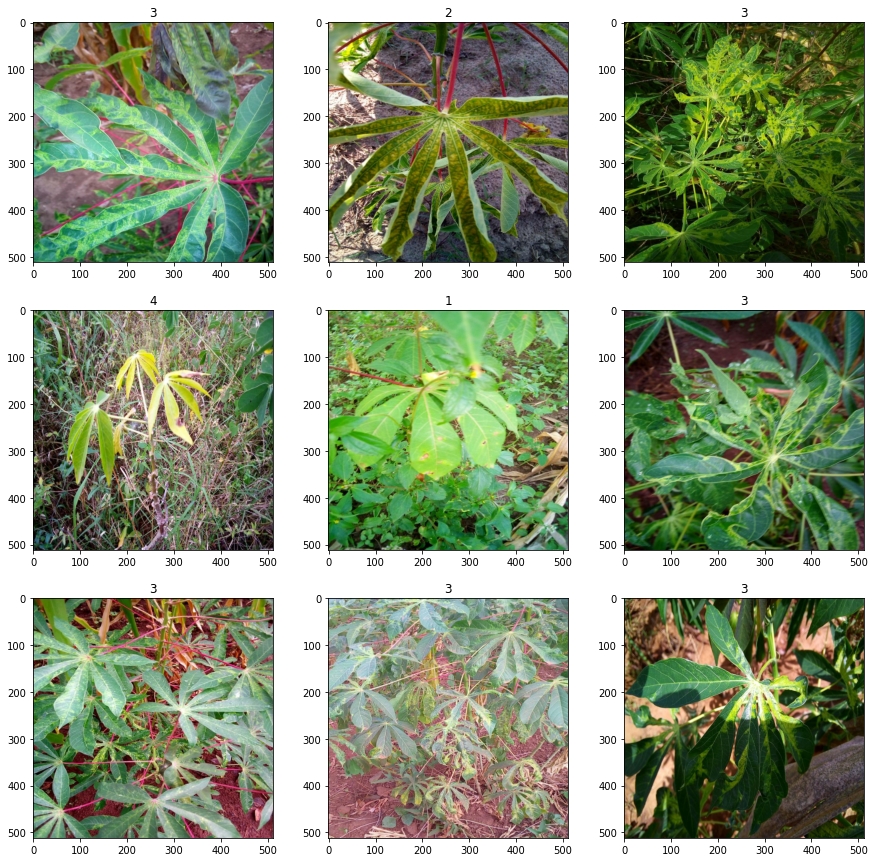

In [16]:
import matplotlib.pyplot as plt

for batch in train_ds.take(1).as_numpy_iterator():
  print('X shape: ', batch[0].shape)
  print('X min, max: ', np.min(batch[0]), np.max(batch[0]))
  fig, axes = plt.subplots(3, 3 , figsize = (15, 15))
  for x, y, ax in zip(batch[0], batch[1], axes.flat):
    ax.imshow(x /255)
    ax.set_title(y)

In [17]:
for example in train_ds.take(1).as_numpy_iterator():
  print('Y: ', example[1].shape)
  print('Y: ', example[1])

Y:  (24,)
Y:  [2 0 4 2 2 3 1 3 0 2 3 4 3 1 3 3 3 3 4 1 3 3 4 0]


In [ ]:
from tensorflow.keras.callbacks import Callback
class PlotLearningCurve(Callback):

  def __init__(self, batch_interval = 32):
    super().__init__(batch_interval)
    self.batch_interval = batch_interval

  def on_epoch_end(self, epoch, logs=None):
    if epoch % self.batch_interval == 0:
      plt.plot(history['loss'], label = 'train')
      plt.plot(history['val_loss'], label = 'val')
      plt.legend();


In [ ]:
#from cassava_farmer.data import get_image_generator_local
#from cassava_farmer.model import build_aug_eff_model, save_model_to_gcp
#from cassava_farmer.gcs import storage_upload_file, storage_upload_folder

from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


es = EarlyStopping(patience=1000, restore_best_weights = True)

model = build_aug_eff_model((512, 512, 3), 5)
#model = build_model()
#model = build_simple_model()


history = model.fit(
  train_ds,
  epochs=1000,
  #batch_size=batch_size,
  class_weight = class_weights,
  steps_per_epoch=steps_per_epoch,
  validation_data=val_ds,
  validation_steps=validation_steps,
  validation_batch_size=batch_size,
  callbacks=[es, PlotLearningCurve()]
  ).history


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense_6 (Dense)             (None, 120)               153720    
                                                                 
 dropout_4 (Dropout)         (None, 120)               0         
                                                                 
 dense_7 (Dense)             (None, 12)                1452      
                                                                 
 dropout_5 (Dropout)         (None, 12)                0         
                                                                 
 dense_8 (Dense)             (None, 5)                 65        
                                                                 
Total params: 4,204,808
Trainable params: 155,237
Non-

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['loss'], label = 'train')
plt.plot(history['val_loss'], label = 'val')
plt.title(f'bs:{str(batch_size)} ')
plt.legend();


In [ ]:
#save learning curve 
plt.savefig('learning_curve.png')

In [ ]:
import json
from datetime import datetime
from google.colab import files

history_file_name = f'history/{datetime.now().strftime("history_%Y-%m-%d_%H-%M-%S")}.json'
out_file = open(history_file_name, "w")
json.dump(history, out_file, indent="")
out_file.close()
files.download(f"/content/{history_file_name}")
#storage_upload_file(history_file_name)

# save
model.save('models/aug_eff_model')
# save
!zip -r /content/models/eff_model_colab.zip /content/models/aug_eff_model
# download
files.download("/content/models/eff_model_colab.zip")
#storage_upload_folder('models/aug_eff_model_test')

In [ ]:
##Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history['accuracy'], label = 'train')
plt.plot(history['val_accuracy'], label = 'val')
plt.title(f'')
plt.legend();
plt.savefig('learning_curve_accuracy.png')

In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(train_ds.take(20))

y_pred

In [ ]:
#test_batch = train_ds.take(100)
#test_batch[1]

In [ ]:
#list(train_ds.as_numpy_iterator())[0]

In [ ]:
for example in train_ds.take(1).as_numpy_iterator():
  print('X: ', example[0].shape)
  print('Y: ', example[1].shape)

In [ ]:
#classification_report(y_pred, )

In [ ]:
print('max train accuracy', max(history['accuracy']))
print('max val accuracy', max(history['val_accuracy']))

In [ ]:
# from cassava_farmer.trainer import Trainer
# trainer = Trainer('colab')
# trainer.train(data_path = 'gcs_bucket/cassava_farmer/train_images')

In [ ]:
# # load previous history
# import json

# history = json.load(open('/content/history/history_2022-02-27_16-43-50'))

# history

In [ ]:


label_map = {
    '0': 'cassava_bacterial_blight', #1087
    '1': 'cassava_brown_streak_disease', #2189
    '2': 'cassava_green_mottle', #2386
    '3': 'cassava_mosaic_disease', #13158
    '4': 'healthy' #2577
}

In [ ]:
test_model = build_model()
test_model.build((None, 512, 512, 3))
test_model.summary()

In [ ]:
#test_model = build_model()

# history = test_model.fit(
#                 train_ds,
#                 epochs=1,
#                 class_weights = class_weights
#                 #batch_size=batch_size,
#                 steps_per_epoch=steps_per_epoch,
#                 validation_data=val_ds,
#                 validation_steps=validation_steps,
#                 validation_batch_size=batch_size).history
#                 #callbacks=[es]